## This is just a simple Notebook to analyse the results of the "count_lines_with_dillution"-method in "img_preprocessing"
The notebook is used for analyzing data by diluting images, counting the affected number of rows, and plotting the results.

****

In [13]:
import time
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import logging

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
)


## Class of preprocessing
This notebook contains a cut down version of the preprocess class in the "preprocessing.py". Here, only the necessitys are used.

In [14]:
class preprocess:
    def __init__(self, img_path):
        """Initialize the image processor with the image path"""
        self.img_path = img_path

    def load_image(self):
        """Load the image from the specified path"""
        self.img = cv2.imread(self.img_path)
        if self.img is None:
            raise ValueError(f"Image not found at {self.img_path}")
        return self.img

    def get_image_name(self):
        """Get the name of the image file without the path"""
        return os.path.basename(self.img_path)
    
    def crop_img(self):
        """Crop the image by 5% from every edge"""
        if self.img is None:
            raise ValueError(
                "Image not loaded. Please call load_image() before crop_img()."
            )
        height, width = self.img.shape[:2]
        crop_x = int(width * 0.05)
        crop_y = int(height * 0.05)
        self.img = self.img[crop_y : height - crop_y, crop_x : width - crop_x]
        return self.img
    
    def greyscale(self):
        """Convert the image to greyscale and apply a binary threshold"""
        if self.img is None:
            raise ValueError(
                "Image not loaded. Please call load_image() before greyscale()."
            )
        self.img = cv2.cvtColor(self.img, cv2.COLOR_BGR2GRAY)
        logging.info("Converting to greyscale...")

        # Apply a binary threshold to convert the greyscale image to black and white
        _, self.img = cv2.threshold(
            self.img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
        )

        return self.img
    
    def dilate_img(self, x_kernel_size: int):
        """Dilate the image to enhance the features"""
        if self.img is None:
            raise ValueError(
                "Image not loaded. Please call load_image() before dilate_img()."
            )
        # dilute the image to enhance the features, (especially sideways)
        kernel = np.ones((1, x_kernel_size), np.uint8)
        self.img = cv2.dilate(self.img, kernel, iterations=1)
        logging.info("Dilating the image...")
        return self.img

    def line_segmentation(self):
        """Segment the image into lines using contours"""
        if self.img is None:
            raise ValueError(
                "Image not loaded. Please call load_image() before line_segmentation()."
            )

        # Find contours in the image
        contours, hierarchy = cv2.findContours(
            self.img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
        )

        # Sort contours by their y-coordinate (top to bottom)
        self.sorted_contours_lines = sorted(
            contours, key=lambda ctr: cv2.boundingRect(ctr)[1]
        )

        # Draw contours on the image
        img_with_contours = cv2.cvtColor(self.img, cv2.COLOR_GRAY2BGR)
        for ctr in self.sorted_contours_lines:
            x, y, w, h = cv2.boundingRect(ctr)
            cv2.rectangle(img_with_contours, (x, y), (x + w, y + h), (41, 55, 214), 10)
        self.img = img_with_contours

        logging.info(f"Number of contours found: {len(self.sorted_contours_lines)}")

        # Return the processed image and the number of contours
        return self.img, len(self.sorted_contours_lines)

    def remove_bad_segementaion(self):
        """Remove bad segmentations based on size"""
        if self.img is None:
            raise ValueError(
                "Image not loaded. Please call load_image() before remove_bad_segementaion()."
            )

        # Get the height and width of the image
        height, width = self.img.shape[:2]
        min_line_width = int(width * 0.7)  # 0.7 is a good value
        min_line_height = int(height * 0.1)  # 0.1 is a good value

        # Filter out bad contours
        filtered_contours = [
            ctr
            for ctr in self.sorted_contours_lines
            if cv2.boundingRect(ctr)[2]
            >= min_line_width * 0.5  # Reduce width threshold
            and cv2.boundingRect(ctr)[3]
            >= min_line_height * 0.1  # Reduce height threshold
        ]

        # filter out contours that are taller in height than width
        filtered_contours = [
            ctr
            for ctr in filtered_contours
            if cv2.boundingRect(ctr)[3] <= cv2.boundingRect(ctr)[2]
        ]

        logging.info(
            f"Number of contours before filtering: {len(self.sorted_contours_lines)}"
        )
        logging.info(f"Number of contours after filtering: {len(filtered_contours)}")

        # Update the sorted_contours_lines with the filtered contours
        self.sorted_contours_lines = filtered_contours
        return self.sorted_contours_lines

    def draw_segmentation(self):
        """Draw the segmented lines on the image"""
        if self.img is None:
            raise ValueError(
                "Image not loaded. Please call load_image() before draw_segmentation()."
            )

        # Draw the segmented lines on the image
        img_with_lines = cv2.cvtColor(self.img, cv2.COLOR_GRAY2BGR)
        for ctr in self.sorted_contours_lines:
            x, y, w, h = cv2.boundingRect(ctr)
            cv2.rectangle(img_with_lines, (x, y), (x + w, y + h), (41, 55, 214), 10)
        self.img = img_with_lines
        return self.img
    
    def count_lines_with_dillution_for_multiple_images(self, image_paths):
        """
        Wrapper function for above. Counts lines with different dilutions for multiple images.
        """
        results = pd.DataFrame(columns=["image_name", "dilution", "number_of_lines"])

        for image_path in image_paths:
            self.img_path = image_path  # Set the image path
            self.load_image()  # Load the image into self.img
            df = self.count_lines_with_dillution()  # Reuse the existing method
            results = pd.concat([results, df], ignore_index=True)

        results.to_csv("line_detection_results_all_images.csv", index=False)
        # return results

    def count_lines_with_dillution(self):
        """This method counts the amount of lines with different dilutions.
        It is modified for testing purposes and will not be used in the final version.
        """
        #! We need to find the right dilution for the image. Doing some digging with the count_script.py
        #! we found out that we need an average of 23 lines per image.

        if self.img is None:
            raise ValueError(
                "Image not loaded. Please call load_image() before count_lines_with_dillution()."
            )

        df = pd.DataFrame(columns=["image_name", "dilution", "number_of_lines"])

        # Save the original image for reuse in the loop
        original_img = self.img.copy()

        # Define the kernel sizes to test
        kernel_sizes = list(range(40, 125, 5))

        # Iterate over the kernel sizes
        for kernel_size in kernel_sizes:
            # Reset to original image at each iteration
            self.img = original_img.copy()

            # Apply preprocessing steps
            self.greyscale()
            self.dilate_img(kernel_size)

            # Get the processed image and the number of lines from line_segmentation
            processed_img, sorted_contours_lines = self.line_segmentation()

            # Remove bad segmentations
            sorted_contours_lines = self.remove_bad_segementaion()

            # Append the result to the DataFrame
            df = pd.concat(
                [
                    df,
                    pd.DataFrame(
                        {
                            "image_name": [self.get_image_name()],
                            "dilution": [kernel_size],
                            "number_of_lines": [len(sorted_contours_lines)],
                        }
                    ),
                ],
                ignore_index=True,
            )

        return df



## Main loop

In [15]:
# Get the current working directory
path = os.getcwd()

# Get a list of all files in the directory
filelist = os.listdir(path)

# Filter for JPEG, PNG images
jpeg_images = [
    os.path.join(path, file)
    for file in filelist
    if file.lower().endswith((".jpg", ".jpeg", ".png"))
]

# Check if there are any images to process
if not jpeg_images:
    logging.info("No JPEG images found in the current folder.")
else:
    # Create an instance of the preprocess class for each image
    for img_path in jpeg_images:
        file_name = os.path.basename(img_path)
        logging.info(f"Processing image: {file_name}")

        # Create an instance of the preprocess class
        current_img = preprocess(img_path)

        # Load and preprocess the image
        current_img.load_image()
        current_img.crop_img()

    # Execute count_lines_with_dillution_for_multiple_images on all images
    logging.info("Executing count_lines_with_dillution_for_multiple_images...")
    current_img.count_lines_with_dillution_for_multiple_images(jpeg_images)


2025-05-03 14:06:20,520 - INFO - Processing image: bsb00095929.0011.jpeg
2025-05-03 14:06:20,592 - INFO - Processing image: bsb00046500.0011.jpeg
2025-05-03 14:06:20,778 - INFO - Processing image: bsb00054504.0016.jpeg
2025-05-03 14:06:20,992 - INFO - Processing image: bsb00050531.0011.jpeg
2025-05-03 14:06:21,112 - INFO - Processing image: bsb00072162.0056.jpeg
2025-05-03 14:06:21,343 - INFO - Processing image: bsb00047183.0011.jpeg
2025-05-03 14:06:21,639 - INFO - Processing image: bsb00071185.0006.jpeg
2025-05-03 14:06:21,781 - INFO - Processing image: bsb00071369.0002.jpeg
2025-05-03 14:06:22,061 - INFO - Processing image: bsb00104168.0011.jpeg
2025-05-03 14:06:22,150 - INFO - Processing image: bsb00065763.0011.jpeg
2025-05-03 14:06:22,247 - INFO - Processing image: bsb00046285.0011.jpeg
2025-05-03 14:06:22,341 - INFO - Processing image: bsb00065409.0035.jpeg
2025-05-03 14:06:22,565 - INFO - Processing image: bsb00065410.0012.jpeg
2025-05-03 14:06:22,858 - INFO - Processing image: 

In [16]:
df = pd.read_csv("line_detection_results_all_images.csv")
df.head()

,image_name,dilution,number_of_lines
0,bsb00095929.0011.jpeg,40,0
1,bsb00095929.0011.jpeg,45,0
2,bsb00095929.0011.jpeg,50,0
3,bsb00095929.0011.jpeg,55,0
4,bsb00095929.0011.jpeg,60,0


In [17]:
unique_image_names = df["image_name"].nunique()
print(f"Number of unique entries in 'image_name': {unique_image_names}")

Number of unique entries in 'image_name': 17


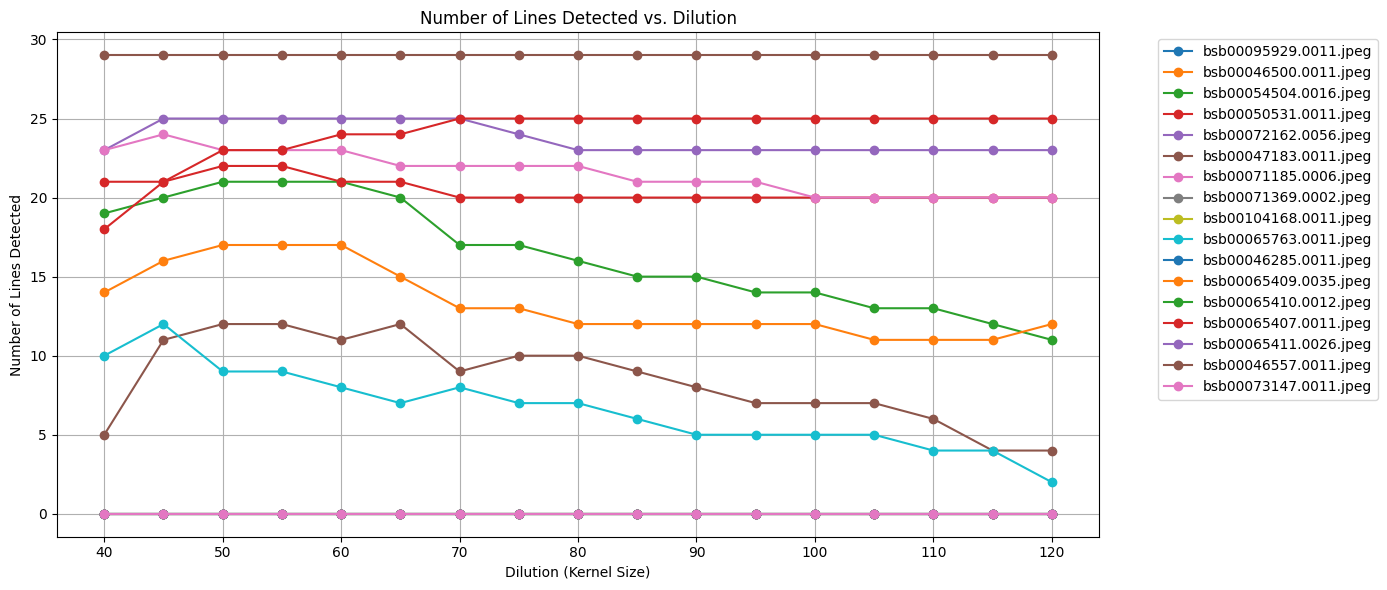

In [18]:
# Plot the results using matplotlib
plt.figure(figsize=(10, 6))
for image_name in df["image_name"].unique():
    image_df = df[df["image_name"] == image_name]
    plt.plot(
        image_df["dilution"],
        image_df["number_of_lines"],
        label=image_name,
        marker="o",
    )

plt.title("Number of Lines Detected vs. Dilution")
plt.xlabel("Dilution (Kernel Size)")
plt.ylabel("Number of Lines Detected")
plt.gcf().set_size_inches(14, 6)
# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()

In [19]:
average_lines_per_image = df.groupby("image_name")["number_of_lines"].mean().mean()
print(f"Average number of lines in a picture: {average_lines_per_image:.2f}")

median_lines_per_image = df.groupby("image_name")["number_of_lines"].median().median()
print(f"Median number of lines in a picture: {median_lines_per_image:.2f}")

Average number of lines in a picture: 9.63
Median number of lines in a picture: 7.00


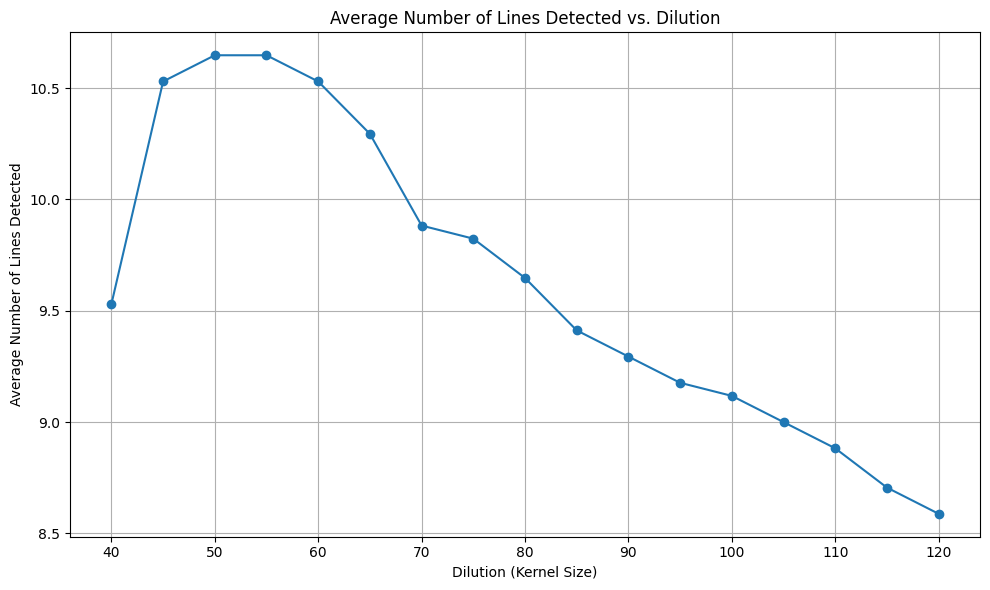

In [20]:
# Group by dilution and calculate the mean number of lines
average_lines_per_dilution = df.groupby("dilution")["number_of_lines"].mean()

# Plot the results
plt.figure(figsize=(10, 6))
average_lines_per_dilution.plot(kind="line", marker="o")
plt.title("Average Number of Lines Detected vs. Dilution")
plt.xlabel("Dilution (Kernel Size)")
plt.ylabel("Average Number of Lines Detected")
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
images_with_few_lines = df[df["number_of_lines"] <= 5]["image_name"].unique()
print("Images with 5 or fewer lines:")
for image in images_with_few_lines:
    print(image)

Images with 5 or fewer lines:
bsb00095929.0011.jpeg
bsb00046500.0011.jpeg
bsb00047183.0011.jpeg
bsb00071369.0002.jpeg
bsb00104168.0011.jpeg
bsb00065763.0011.jpeg
bsb00046285.0011.jpeg
bsb00065410.0012.jpeg
bsb00065411.0026.jpeg
bsb00073147.0011.jpeg
